In [9]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# --- Settings ---
folder_path = '/Users/user/Python/Matches/WWC/'
output_file = 'player_cross_summary.xlsx'

# --- Helper Functions ---
def has_qualifier(row, q_id):
    for i in range(20):
        q_col = f'qualifier/{i}/qualifierId'
        if q_col in row and row[q_col] == q_id:
            return True
    return False

def get_qualifier_value(row, q_id):
    for i in range(20):
        q_id_col = f'qualifier/{i}/qualifierId'
        q_val_col = f'qualifier/{i}/value'
        if q_id_col in row and row[q_id_col] == q_id:
            return float(row[q_val_col]) if pd.notnull(row[q_val_col]) else None
    return None

def calculate_distance(x, y):
    return np.sqrt((100 - x)**2 + (50 - y)**2)

def calculate_angle(x, y):
    b = 100 - x
    if b <= 0:
        return 0
    return np.arctan(7.32 * 0.5 / b) * 2

# --- Store all crosses ---
all_crosses = []

# --- Process Each File ---
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        df['eventTime'] = df['timeMin'] * 60 + df['timeSec']

        passes = df[df['typeId'] == 1].copy()
        passes['isCross'] = passes.apply(lambda r: has_qualifier(r, 2), axis=1)
        passes['endX'] = passes.apply(lambda r: get_qualifier_value(r, 140), axis=1)
        passes['endY'] = passes.apply(lambda r: get_qualifier_value(r, 141), axis=1)
        passes['isAssist'] = passes.apply(lambda r: has_qualifier(r, 210), axis=1)
        passes['isSecondAssist'] = passes.apply(lambda r: has_qualifier(r, 218), axis=1)

        shots = df[df['typeId'].isin([13, 14, 15, 16])].copy()
        shots['eventTime'] = shots['timeMin'] * 60 + shots['timeSec']

        def find_key_pass(row):
            future = shots[(shots['periodId'] == row['periodId']) & (shots['eventTime'] > row['eventTime'])]
            if not future.empty:
                return future.iloc[0]['typeId']
            return None

        passes['linkedShotTypeId'] = passes.apply(find_key_pass, axis=1)
        passes['isKeyPass'] = passes['linkedShotTypeId'].isin([13, 14, 15])

        crosses = passes[passes['isCross']].copy()
        for col in ['outcome', 'periodId', 'timeMin', 'timeSec']:
            if col in crosses.columns:
                crosses = crosses.drop(columns=[col])
        crosses = crosses.merge(passes[['id', 'outcome', 'periodId', 'timeMin', 'timeSec']], on='id', how='left')
        crosses['outcome'] = pd.to_numeric(crosses['outcome'], errors='coerce').fillna(0).astype(int)

        crosses['distanceToGoal'] = crosses.apply(lambda r: calculate_distance(r['endX'], r['endY']), axis=1)
        crosses['angleToGoal'] = crosses.apply(lambda r: calculate_angle(r['endX'], r['endY']), axis=1)
        crosses['angleScore'] = crosses['angleToGoal'] / np.pi
        crosses['distanceScore'] = 1 - (crosses['distanceToGoal'] / np.sqrt(100**2 + 50**2))
        crosses['eventBonus'] = 0
        crosses.loc[crosses['isKeyPass'], 'eventBonus'] += 0.15
        crosses.loc[crosses['isAssist'], 'eventBonus'] += 0.30
        crosses['successBonus'] = crosses['outcome'].apply(lambda x: 0.2 if x == 1 else 0)

        def cross_zone(x, y):
            if y < 33: return 'Right Wing'
            elif y > 67: return 'Left Wing'
            return 'Central'

        crosses['crossZone'] = crosses.apply(lambda r: cross_zone(r['x'], r['y']), axis=1)
        crosses['deepCross'] = crosses['x'] < 70
        crosses['zoneBonus'] = crosses['crossZone'].map({'Left Wing': 0.1, 'Right Wing': 0.1, 'Central': 0.0})
        crosses['depthBonus'] = crosses['deepCross'].apply(lambda x: -0.05 if x else 0.05)

        df['eventTime'] = df['timeMin'] * 60 + df['timeSec']
        crosses['boxPressureCount'] = 0
        crosses['oppPPDA'] = 0.0
        crosses['oppDefActionHeight'] = 0.0
        crosses['oppClearanceSuccess'] = 0.0

        for idx, row in crosses.iterrows():
            attacking_team = row['contestantId']
            period = row['periodId']
            time = row['timeMin'] * 60 + row['timeSec']
            teams = df['contestantId'].dropna().unique()
            opponent_team = [t for t in teams if t != attacking_team]
            if not opponent_team:
                continue
            opponent_team = opponent_team[0]

            box_events = df[
                (df['contestantId'] == opponent_team) &
                (df['periodId'] == period) &
                (df['eventTime'] >= time) &
                (df['x'] > 85) & (df['y'] > 20) & (df['y'] < 80) &
                (df['typeId'].isin([4, 12, 44]))
            ]

            def_actions = df[(df['contestantId'] == opponent_team) & (df['typeId'].isin([4, 44, 5]))]
            passes_att = df[(df['contestantId'] == attacking_team) & (df['typeId'] == 1)]
            ppda = len(passes_att) / (len(def_actions) + 1e-5)
            opp_def_x = df[(df['contestantId'] == opponent_team) & (df['typeId'].isin([4, 5, 12]))]['x'].mean()
            clearances = df[(df['contestantId'] == opponent_team) & (df['typeId'] == 12)]
            clearance_success = clearances['outcome'].sum() / len(clearances) if len(clearances) > 0 else 0

            crosses.at[idx, 'boxPressureCount'] = len(box_events)
            crosses.at[idx, 'oppPPDA'] = ppda
            crosses.at[idx, 'oppDefActionHeight'] = opp_def_x
            crosses.at[idx, 'oppClearanceSuccess'] = clearance_success

        # Final xC
        crosses['xC_final'] = (
            0.3 * crosses['angleScore'] +
            0.3 * crosses['distanceScore'] +
            0.15 * crosses['eventBonus'] +
            0.1 * crosses['successBonus'] +
            0.1 * crosses['zoneBonus'] +
            0.05 * crosses['depthBonus'] +
            -0.02 * crosses['boxPressureCount'] +
            0.05 * (crosses['oppPPDA'] > 12).astype(int) +
            -0.03 * (crosses['oppDefActionHeight'] - 40) +
            -0.1 * (1 - crosses['oppClearanceSuccess'])
        )

        all_crosses.append(crosses)

# --- Combine All Crosses ---
all_crosses_df = pd.concat(all_crosses, ignore_index=True)

# --- Player Summary ---
summary = all_crosses_df.groupby(['playerName', 'contestantId']).agg(
    num_crosses=('id', 'count'),
    num_assists=('isAssist', 'sum'),
    num_key_passes=('isKeyPass', 'sum'),
    avg_xC=('xC_final', 'mean')
).reset_index()

# --- Export Summary ---
summary.to_excel(output_file, index=False)
print(f"✅ Player summary saved: {output_file}")

✅ Player summary saved: player_cross_summary.xlsx


In [16]:
import os
import pandas as pd
import numpy as np
import joblib

# --- Settings ---
new_folder_path = '/Users/user/Python/Matches/WWC'  # Update path as needed
model_file = 'xc_model.pkl'
output_file = 'predicted_crosses.csv'

# --- Helper Functions ---
def has_qualifier(row, q_id):
    for i in range(20):
        if f'qualifier/{i}/qualifierId' in row and row[f'qualifier/{i}/qualifierId'] == q_id:
            return True
    return False

def get_qualifier_value(row, q_id):
    for i in range(20):
        q_id_col = f'qualifier/{i}/qualifierId'
        q_val_col = f'qualifier/{i}/value'
        if q_id_col in row and row[q_id_col] == q_id:
            return float(row[q_val_col]) if pd.notnull(row[q_val_col]) else None
    return None

def calculate_distance(x, y):
    return np.sqrt((100 - x)**2 + (50 - y)**2)

def calculate_angle(x, y):
    b = 100 - x
    return np.arctan(7.32 * 0.5 / b) * 2 if b > 0 else 0

def cross_zone(x, y):
    if y < 33: return 'Right Wing'
    elif y > 67: return 'Left Wing'
    return 'Central'

# --- Collect Crosses from All CSVs ---
crosses_list = []

for filename in os.listdir(new_folder_path):
    if filename.endswith('.csv'):
        df = pd.read_csv(os.path.join(new_folder_path, filename))
        df['eventTime'] = df['timeMin'] * 60 + df['timeSec']

        passes = df[df['typeId'] == 1].copy()
        passes['isCross'] = passes.apply(lambda r: has_qualifier(r, 2), axis=1)
        passes['endX'] = passes.apply(lambda r: get_qualifier_value(r, 140), axis=1)
        passes['endY'] = passes.apply(lambda r: get_qualifier_value(r, 141), axis=1)

        crosses = passes[passes['isCross']].copy()
        crosses['distanceToGoal'] = crosses.apply(lambda r: calculate_distance(r['endX'], r['endY']), axis=1)
        crosses['angleToGoal'] = crosses.apply(lambda r: calculate_angle(r['endX'], r['endY']), axis=1)
        crosses['angleScore'] = crosses['angleToGoal'] / np.pi
        crosses['distanceScore'] = 1 - (crosses['distanceToGoal'] / np.sqrt(100**2 + 50**2))

        crosses['eventBonus'] = 0  # placeholder
        crosses['successBonus'] = 0  # placeholder

        crosses['crossZone'] = crosses.apply(lambda r: cross_zone(r['x'], r['y']), axis=1)
        crosses['deepCross'] = crosses['x'] < 70
        crosses['zoneBonus'] = crosses['crossZone'].map({'Left Wing': 0.1, 'Right Wing': 0.1, 'Central': 0.0})
        crosses['depthBonus'] = crosses['deepCross'].apply(lambda x: -0.05 if x else 0.05)

        crosses['boxPressureCount'] = 0
        crosses['oppPPDA'] = 0.0
        crosses['oppDefActionHeight'] = 0.0
        crosses['oppClearanceSuccess'] = 0.0

        for idx, row in crosses.iterrows():
            attacking_team = row['contestantId']
            period = row['periodId']
            time = row['eventTime']
            teams = df['contestantId'].dropna().unique()
            opponent_team = [t for t in teams if t != attacking_team]
            if not opponent_team:
                continue
            opponent_team = opponent_team[0]

            box_events = df[
                (df['contestantId'] == opponent_team) &
                (df['periodId'] == period) &
                (df['eventTime'] >= time) &
                (df['x'] > 85) & (df['y'] > 20) & (df['y'] < 80) &
                (df['typeId'].isin([4, 12, 44]))
            ]

            def_actions = df[(df['contestantId'] == opponent_team) & (df['typeId'].isin([4, 44, 5]))]
            passes_att = df[(df['contestantId'] == attacking_team) & (df['typeId'] == 1)]
            ppda = len(passes_att) / (len(def_actions) + 1e-5)
            opp_def_x = df[(df['contestantId'] == opponent_team) & (df['typeId'].isin([4, 5, 12]))]['x'].mean()
            clearances = df[(df['contestantId'] == opponent_team) & (df['typeId'] == 12)]
            clearance_success = clearances['outcome'].sum() / len(clearances) if len(clearances) > 0 else 0

            crosses.at[idx, 'boxPressureCount'] = len(box_events)
            crosses.at[idx, 'oppPPDA'] = ppda
            crosses.at[idx, 'oppDefActionHeight'] = opp_def_x
            crosses.at[idx, 'oppClearanceSuccess'] = clearance_success

        crosses_list.append(crosses)

# --- Combine Data ---
new_crosses_df = pd.concat(crosses_list, ignore_index=True)

# --- Load Model ---
model = joblib.load(model_file)

# --- Model Features ---
features = [
    'angleScore', 'distanceScore', 'eventBonus', 'successBonus',
    'zoneBonus', 'depthBonus', 'boxPressureCount', 'oppPPDA',
    'oppDefActionHeight', 'oppClearanceSuccess',
    'x', 'y', 'endX', 'endY'
]

# --- Predict ---
X_new = new_crosses_df[features].fillna(0)
new_crosses_df['predicted_xC'] = model.predict(X_new)

# --- Export to CSV ---
columns_to_export = features + ['predicted_xC']
new_crosses_df.to_csv(output_file, columns=columns_to_export, index=False)

print(f"✅ Predictions saved to {output_file}")


✅ Predictions saved to predicted_crosses.csv


/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_54968/2380134920.py:12: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


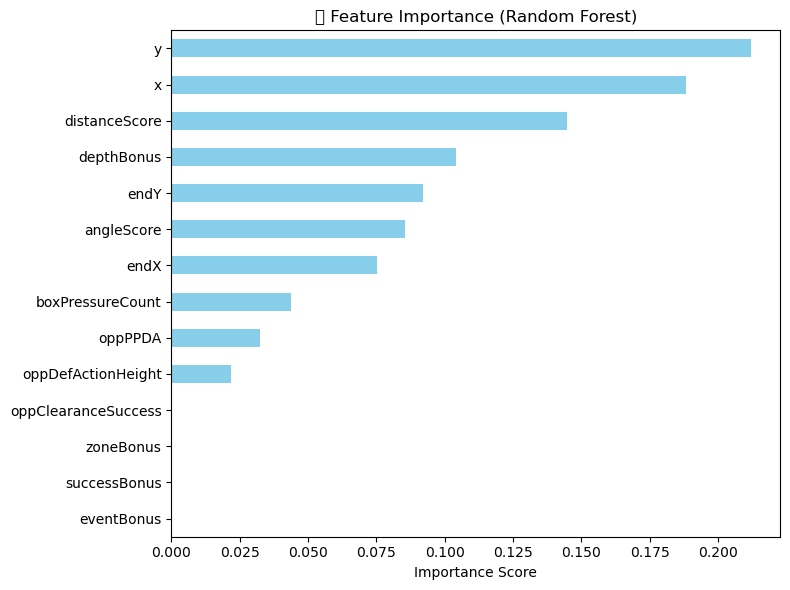

/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_54968/2380134920.py:22: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


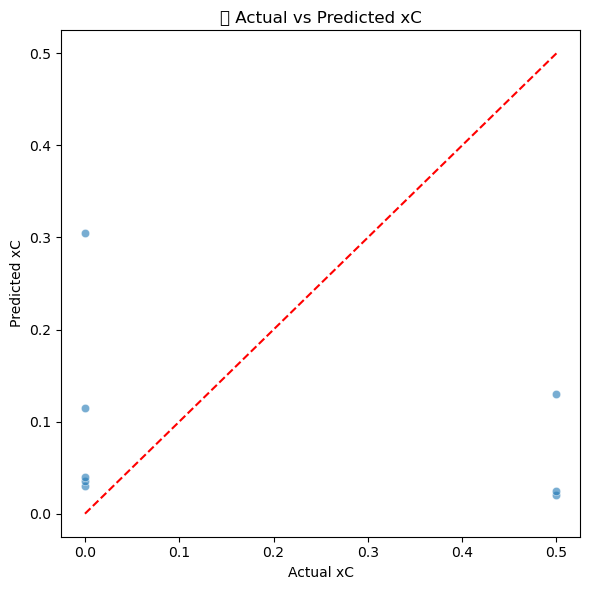

/var/folders/vh/gd9x5_d94g33w411t0md800c0000gn/T/ipykernel_54968/2380134920.py:32: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


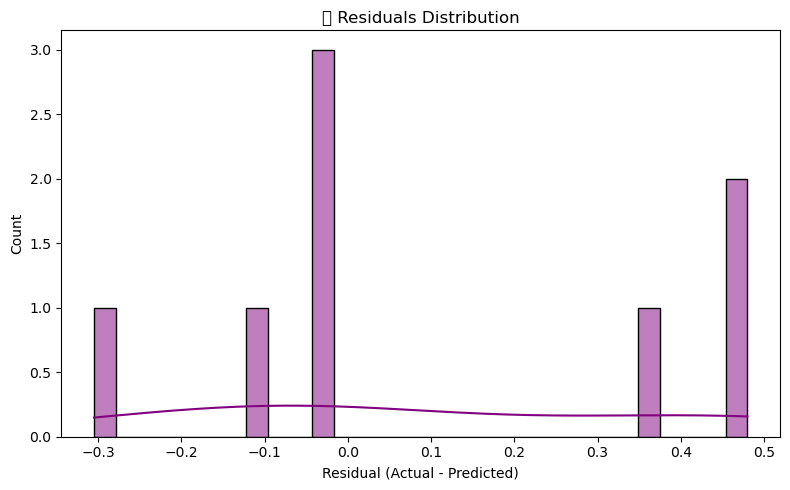

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Feature Importance ---
importances = model.feature_importances_
feat_importance = pd.Series(importances, index=features).sort_values(ascending=True)

plt.figure(figsize=(8, 6))
feat_importance.plot(kind='barh', color='skyblue')
plt.title("🔍 Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# --- 2. Actual vs Predicted ---
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual xC")
plt.ylabel("Predicted xC")
plt.title("🎯 Actual vs Predicted xC")
plt.tight_layout()
plt.show()

# --- 3. Residuals Plot ---
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.title("📉 Residuals Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.tight_layout()
plt.show()


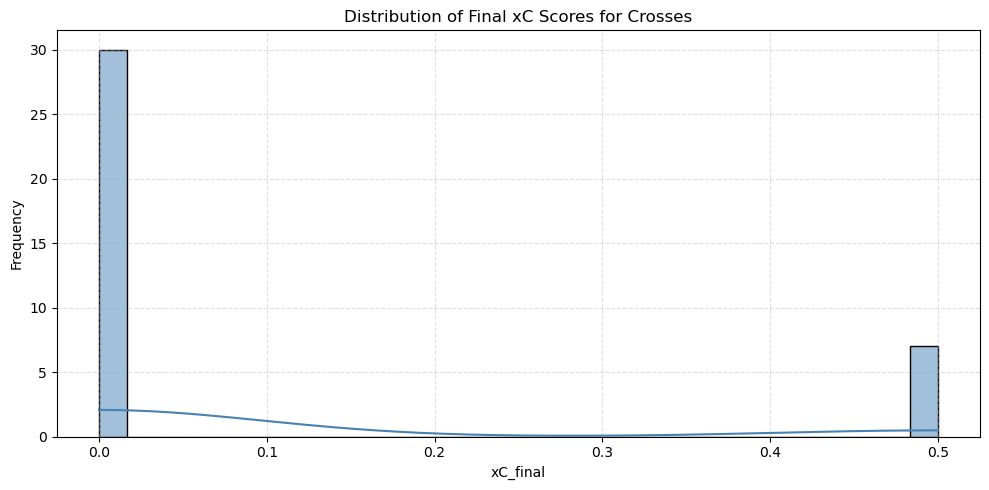

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(all_crosses_df['xC_final'], bins=30, kde=True, color='steelblue')
plt.title('Distribution of Final xC Scores for Crosses')
plt.xlabel('xC_final')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
